# German Traffic Signs Prediction using AWS Sagemaker

## Introduction

This is the final project for AICamp's Full Stack Deep Learning using Amazon Sagemaker (Cohort #8) that ran from September 15th to October 8th, 2020. The course content was divided into two parts. The first focused on image classification and the second on time series forecasting. In both instances, once a model is trained, it is then deployed on AWS for inference purposes.

Here I have chosen an image classification project to predict German Traffic Signs. The dataset can be found [here](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign). There are a total 43 classes of traffic signs ranging from speed limit to warning signs.

The motivation is rooted in the application of self-driving cars where internal cameras have to immediately detect and classify traffic signs in various conditions, i.e. daylight, night time, partially visible, low image quality, etc for the safety of passengers and pedestrians.

To that end, this notebook contains predictions first for 5 selected types of traffic signs and finally making a prediction for all 43 classes.

One of the most important take-aways for this project is the importance of shuffling the data in the lst file that is ingested by AWS Sagemaker for training and validation. Because if this is not done, the training accuracy is near perfect above 99% at least for this dataset but can dip below 40% for the validation and testing. Hence, this has to be kept in mind at all times.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import subprocess
import glob
import json, requests
from pathlib import Path

import base64   # To convert image to base64 string

import random
from random import randrange

random.seed(2022)

plt.rcParams.update({'font.size': 18})


## Some Light EDA

In [2]:
main_folder = './data/Train/'

# This calls an internal script to change directory names of 0-9 to 00-09. 
subprocess.call(['sh', './data/Train/change_dir_name.sh'])


1

In [3]:
# Since all the files end with the same extension, then we can use glob

# The commented code below is the nested structure for the list comprehension version
#for f in os.scandir(main_folder):
#    if f.is_dir():
#        print(f.path)

# This line checks the number 
subfolders = sorted([f.path for f in os.scandir(main_folder) if f.is_dir()])

num_files = []
sample_images = []
list_all_images = []
folder_numfiles = {}

for subclass in subfolders:
    list_files = glob.glob(subclass + '/' + '*png')
    
    # Pick random number between 0,100
    i_num = randrange(100,199)
    
    # List containing the number of files
    num_files.append(len(list_files))
    
    # Grep the class label
    class_label_str = subclass.strip().split('/')[-1]
    
    list_all_images.extend(list_files)
    
    # Dictionary containing images 
    folder_numfiles[class_label_str] = len(list_files)
    
    sample_images.append(list_files[i_num])

#def get_num_files_directory(main_folder):
    

In [4]:
# Get Total number of images
total_number_of_images = sum(folder_numfiles.values())
    
print(total_number_of_images)

39209


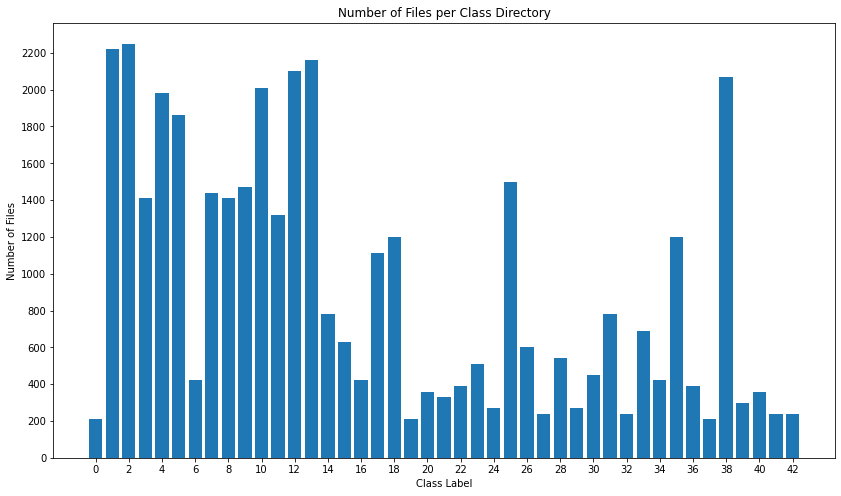

In [5]:
# Let's plot the class distribution
class_label = list(range(0,len(num_files)))

fig = plt.figure(figsize=(14,8))

plt.bar(class_label,num_files);
plt.xticks(np.arange(0, 43, 2))
plt.yticks(np.arange(0,2400,200))
plt.xlabel('Class Label')
plt.ylabel('Number of Files')
plt.title('Number of Files per Class Directory')
plt.savefig('./images/num_class_file_per_directory.svg');
plt.show();

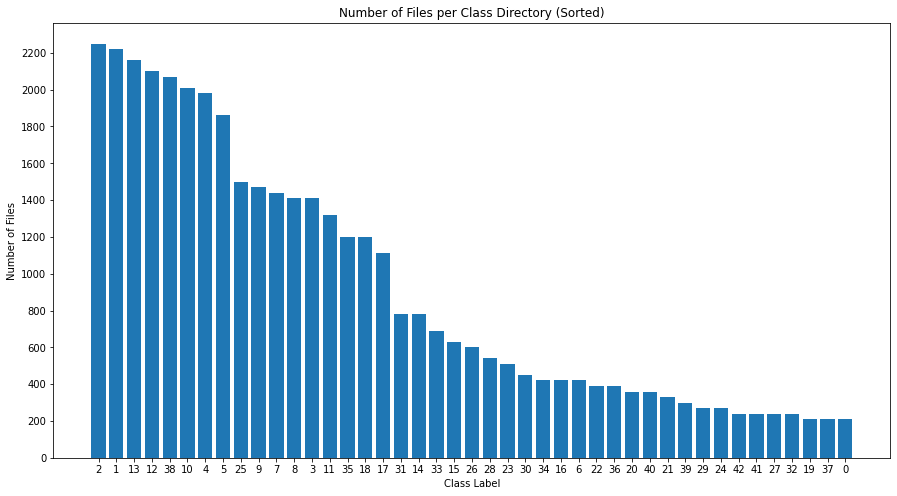

In [6]:
# Let's replot based from highest to lowest
class_label_max_min = list(np.argsort(num_files))[::-1]

fig = plt.figure(figsize=(15,8))

plt.bar(class_label,sorted(num_files,reverse=True), tick_label = class_label_max_min);
plt.xticks(np.arange(0, 43, 1))
plt.yticks(np.arange(0,2400,200))
plt.xlabel('Class Label')
plt.ylabel('Number of Files')
plt.title('Number of Files per Class Directory (Sorted)')
plt.savefig('./images/num_class_file_per_directory_sorted.svg');
plt.show();


In [7]:
# Try and plot images from each class to get an idea of what the images look like.
def show_traffic_signs(num_columns,num_rows,num_classes,images,class_label_inp):
    """
    Function to properly display traffic sign types (randomly chosen)
    
    Inputs:
    -------
    
    num_columns     : Number of columns to display (int)
    
    num_rows        : Number of rows to display (int)
    
    num_classes     : Number of classes (type: list)
    
    images          : path of images (type: list)
    
    class_label_inp : class labels (not the same as num_classes) -> list
    
    Outputs:
    --------
    
    Will save image to an svg file in sub-directory ./images
    
    """
    
    plt.rcParams.update({'font.size': 8})
    fig = plt.figure(figsize=(17, 33))
    
    # For file output purposes
    if len(str(num_classes)) < 2:
        num_classes_str = '0' + str(num_classes)
    else:
        num_classes_str = str(num_classes)

    for i in range(1, num_classes + 1):
        img = mpimg.imread(images[i-1])
        fig.add_subplot(rows, columns, i)
        plt.title('Class {}'.format(class_label_inp[i-1]))
        plt.imshow(img)
    plt.show()

    fig.savefig(f'./images/traffic_signs_num_classes_{num_classes_str}.svg')

In [8]:
# Get min and max pixels on edge for images
#img = mpimg.imread('./data/Train/00/00000_00000_00000.png')
#print(len(folder_content['00']))

# This cell takes a while to run

img_sizes = []

for image_file in list_all_images:
    img = mpimg.imread(image_file)
    img_sizes.append(img.shape)

print(len(img_sizes))

# The number below checks out!

39209


In [9]:
# Now can we check the min and max pixels per image
min_x = img_sizes[0][0]
min_y = img_sizes[0][1]

for im in img_sizes:
    temp_x = im[0]
    temp_y = im[1]
    
    if temp_x < min_x:
        min_x = temp_x
        
    if temp_y < min_y:
        min_y = temp_y
        
print('Smallest x: ', min_x)
print('Smallest y: ', min_y)

Smallest x:  25
Smallest y:  25


It looks like the smallest x and y are 25 and 25, respectively but not necessarily for one image that satisfies for both x and y at the same time. So it looks like the input to AWS of 30,30 is a compromise.

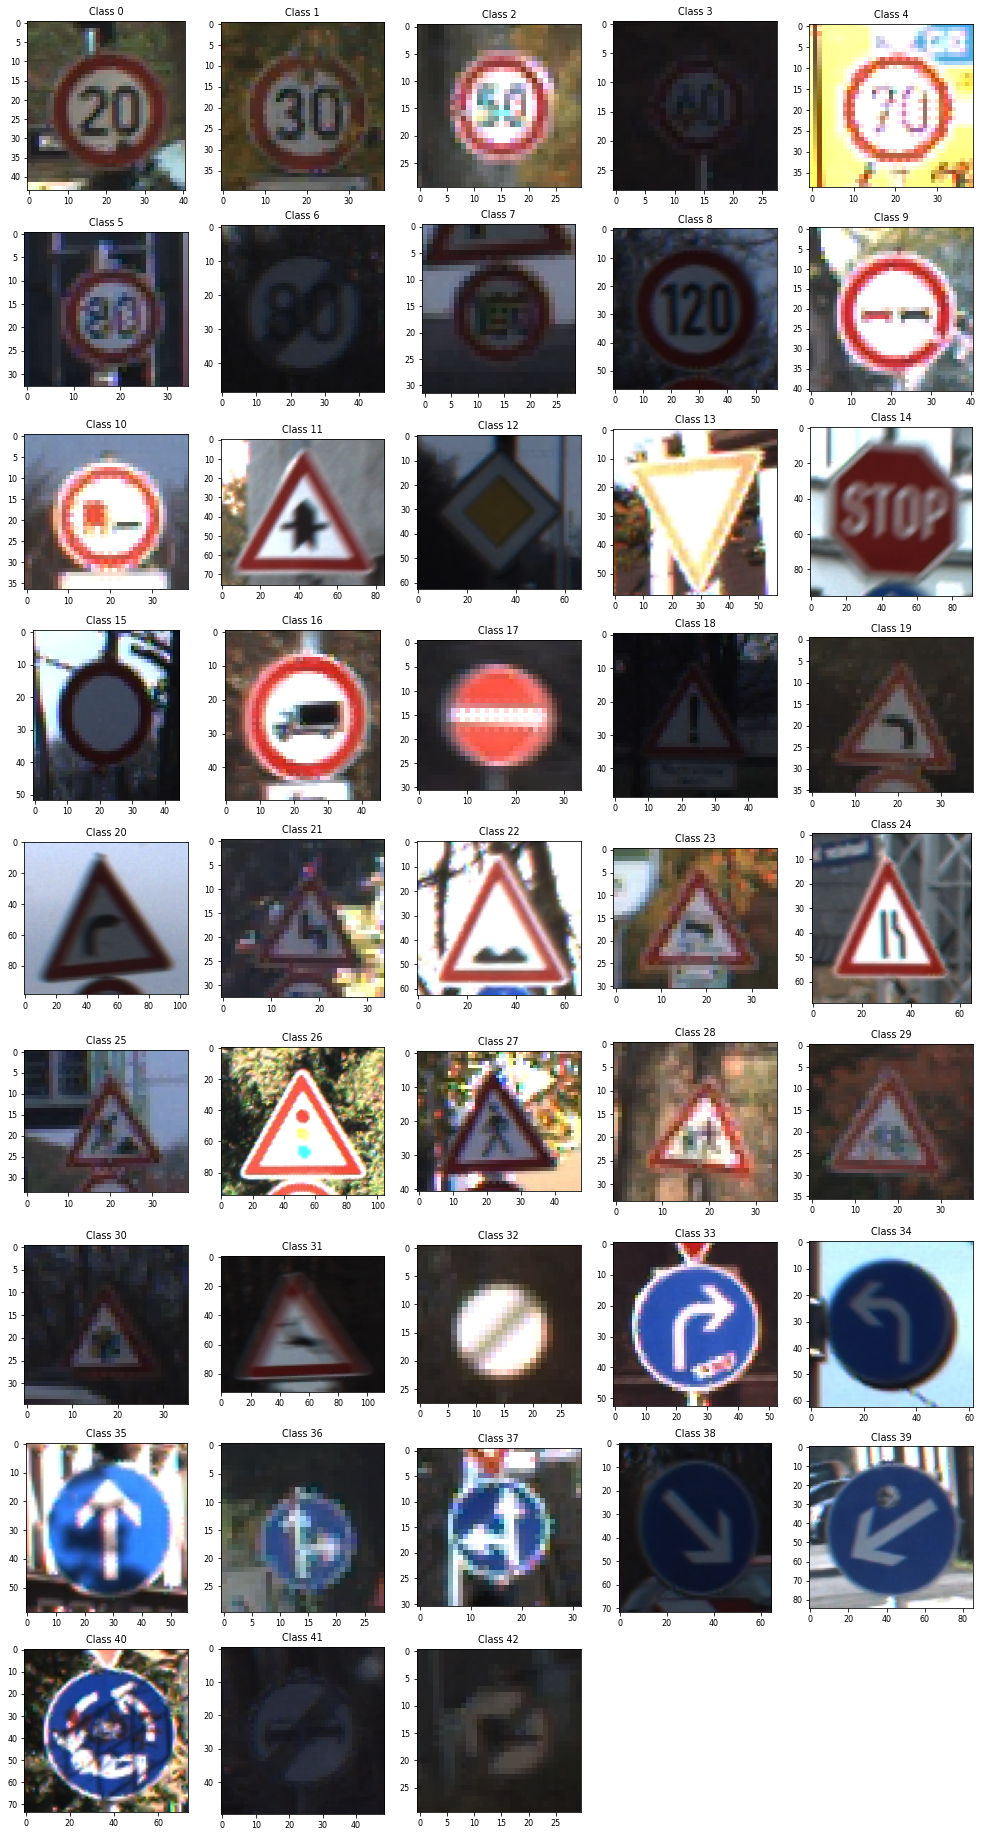

In [10]:
# Lets plot all images and see what they look like
columns = 5
rows = 9
n_classes = 43

show_traffic_signs(columns,rows,n_classes,sample_images,class_label)

From the above plots, the number of files per class is imbalanced. Based on the training and validation performed on AWS, the training accuracy is nearly 99% whereas for validation it has remained stuck at 50%. Hence, there is over-fitting here. There are a few options to do here:

1. Pick a class that has roughly the same number images. Example, images with more than 2,000 images. 
2. Down-sample all images to the minimum. In this case ~200.
3. Re-train from scratch ResNet on AWS on the available dataset (Really Expensive!)

**Let's pick Option 1**

## Going with Option 1

In [11]:
# Let's see which classes have more than 2,000 OR let's pick the top five classes by number
top_n = 5

#for k,v in folder_numfiles.items():
top_5_list_num = sorted(folder_numfiles.items(), key = lambda x: x[1], reverse = True)[:top_n]

top_5_class = [item[0] for item in top_5_list_num]

print(top_5_class)

# Before we feed let's clean it up
top_5_class_cln = sorted(map(int,top_5_class))

['02', '01', '13', '12', '38']


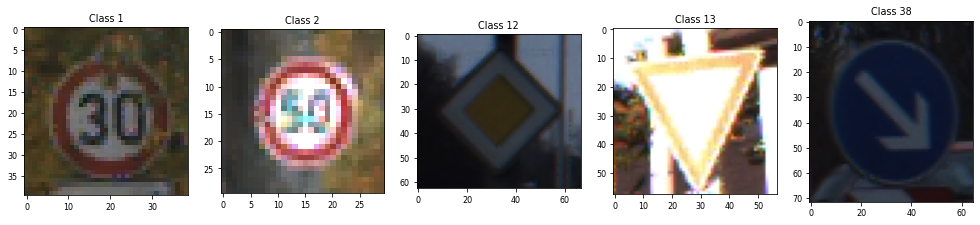

In [12]:
# Let's plot what we are going to predict
columns = 5
rows = 1
n_classes = len(top_5_class_cln)

sample_images_top_5 = [sample_images[i] for i in top_5_class_cln]

show_traffic_signs(columns, rows, n_classes, sample_images_top_5, top_5_class_cln)

It looks like two speed limit signs and three what look like warning signs

## Create lst Files for AWS Sagemaker Training

In [12]:
def generate_lst_file(parent_folder,class_list,
                      train_partition, val_partition, test_partition):
    
    """
    Function to automatically generate a lst file
    
    Inputs:
    -------
    
    parent_folder   : Path of parent folder
    
    class_list      : List array containing class numbers
    
    train_partition : training ratio
    
    val_partition   : validation ratio
    
    test_partition  : test ratio
    
    
    Outputs:
    --------
    
    Will generate three lst files. Train and val are specific to AWS directory structure
    which is S3. The test is based on local files structure.
    
    """
    
    n_classes = len(class_list)
    
    f_train = open("german_traffic_signs_train_{}_classes.lst".format(str(n_classes)), "w")
    f_val   = open("german_traffic_signs_val_{}_classes.lst".format(str(n_classes)), "w")
    f_test  = open("german_traffic_signs_test_{}_classes.lst".format(str(n_classes)), "w")

    # Look at the subfolders in the Train directory
    folders_train = [parent_folder + item for item in sorted(class_list)]

    # Initialize indexing
    # Class labels has to start from zero
    image_index = 0
    class_index = 0

    label_encoding = {}

    # Set seed for uniform random distribution
    random.seed(42)

    train_list = []
    val_list = []
    test_list = []

    # Go through each sub-folder containing images and 
    for name in folders_train:
        label = name.split('/')[-1]
        label_encoding[class_index] = label

        # List of all files in the class folder
        onlyfiles = [f for f in os.listdir(name) if os.path.isfile(os.path.join(name, f))]
    
        for image_names in onlyfiles:
            rand_number = random.uniform(0, 1)
            # Randomly write X percent of the files into test lst
            if (0 < rand_number < train_partition):
                text = str(image_index) + '\t' + str(class_index) + '\t' + 'images/' + label + '/' + image_names
                train_list.append(text)
            
            elif (train_partition < rand_number < val_partition + train_partition):
                text = str(image_index) + '\t' + str(class_index) + '\t' + 'images/' + label + '/' + image_names
                val_list.append(text)
            
            elif (val_partition + train_partition < rand_number < 1):
                # Note!!!!: This is for my local file system only and not for AWS S3
                text = str(image_index) + '\t' + str(class_index) + '\t' + 'data/Train/' + label + '/' + image_names
                
                test_list.append(text)
        
            image_index += 1
        class_index += 1
    
    # Now again set random seed and shuffle the list and write to file
    random.seed(2020)
    
    random.shuffle(train_list)
    random.shuffle(val_list)
    random.shuffle(test_list)
    
    # Write out the lst files for each train, validation and test
    for item in train_list:
        textf = item + '\n'
        f_train.write(textf)
    
    for item in val_list:
        textf = item + '\n'
        f_val.write(textf)
    
    for item in test_list:
        textf = item + '\n'
        f_test.write(textf)

    f_train.close()
    f_val.close()
    f_test.close()
    
    # Print size of each case
    print('Num train     : ', len(train_list))
    print('Num validation: ',len(val_list))
    print('Num test      : ',len(test_list))
    
    # Let's check for duplicates
    set_A = set(train_list).intersection(val_list)
    set_B = set(train_list).intersection(test_list)
    set_C = set(val_list).intersection(test_list)
    
    # Print warning that there are duplicates
    if not (set_A and set_B and set_C):
        print('\nNo Duplicates\n')
    else:
        print('WARNING! There are duplicates in the data!')

In [13]:
# Taken and modified from AICamp sample script
# Create a train and validation lst file
# Partitioning Train-Validation-Split, 70%
train_partition = 0.75
val_partition   = 0.20
test_partition  = 1 - train_partition - val_partition

# This is under the assumption that folders 0 through 9 start with a 0 in front!!!!!
parent_folder = './data/Train/'

# Call function
generate_lst_file(parent_folder,top_5_class,
                  train_partition, val_partition, test_partition)

Num train     :  8147
Num validation:  2110
Num test      :  543

No Duplicates



Great! From the above, we know that there are duplicated observations in each area. After training on AWS, the training and validation accuracy are now both over **99%**. Hence, the real important aspect that was the shuffling of data. This is the understanding at least for now. However, what has not been tested yet is the entire dataset of all 43 classes. Will the accuracy be the same? To test this, regenerate the lst file for all classes but shuffled.

For my own reference, the Training name on Sagemaker is **german-traffic-signs-5cls-model**.

## Create lst File for all 43 Classes (Shuffled)

In [14]:
class_list_count = sorted(folder_numfiles.items(), key = lambda x: x[1], reverse = True)

class_list_all = sorted([item[0] for item in class_list_count])

# Use the same partitioning scheme
generate_lst_file(parent_folder,class_list_all,
                  train_partition, val_partition, test_partition)

Num train     :  29388
Num validation:  7843
Num test      :  1978

No Duplicates



Training on AWS is now complete. Training Accuracy: 98.9% and Validation Accuracy: 98.8%.

**So shuffling the dataset was a huge factor!**

For my own reference, the Training name on Sagemaker is **german-traffic-signs-ALL-cls-model**.

## Make Prediction

### Bytecode Test

In [15]:
# Pick first image in 'german_traffic_signs_test_5_classes.lst' file
# 4691 2 images/12/00012_00046_00016.png -> Class 2

with open('./data/Train/12/00012_00046_00016.png', 'rb') as image_file:
    encoded_string = base64.b64encode(image_file.read())

# print(encoded_string)

### 5-Class Prediction

Code was taken and adapted from Keng S Lee where Lee made a prediction for classifying five types of flowers. Full blog can be found [here](https://medium.com/@aicamp/step-by-step-to-build-image-classifier-using-aws-sagemaker-74ef2d8eb8aa).

In [16]:
# Create a function to convert a png image to a base64 string.
def img_to_base64(img_path):
    """
    Converts an image to base64 code string
    """
    with open(img_path, 'rb') as f:
        img_b64 = base64.b64encode(f.read())
    return img_b64


In [17]:
def predict(api_endpoint, n_classes, lst_file):
    """
    Function to make image prediction
    
    Inputs:
    -------
    
    api_endpoint: The AWS URL address that is visible externally
    
    n_classes: number of classes
    
    lst_file: The lst file name containing the location of the images. Here, the images
              are stored locally.
    
    Outputs:
    --------
    
    cf_matrix: confusion matrix
    
    accuracy: accuracy of predicion
    
    """

    classes = [x for x in range(0,n_classes)]

    # Initialize confusion matrix
    cf_matrix = np.zeros([len(classes)]*2)

    with open(lst_file, 'r') as f:
    
        for line in f:
            global_id, class_id, img_path = line.strip().split('\t')
        
            class_id = int(class_id)
                
            img_path = Path(main_folder)/img_path
                
            data = {'body': img_to_base64(img_path).decode('utf-8')}
            
            # Make prediction and parse probabilites
            res = requests.post(api_endpoint, json=data)
            inference_prob = json.loads(res.text)['body']
            
            # Grab index of maximum probability
            pred_id = np.array(inference_prob).argmax()
        
            print(f'prediction: {img_path}, {pred_id}, {class_id}, {inference_prob[pred_id]}')
            
            # Create Confusion matrix np.array
            cf_matrix[class_id, pred_id] += 1
        
    accuracy = cf_matrix.trace()/cf_matrix.sum()
    
    return cf_matrix,accuracy

In [18]:
# Make sure the API endpoint url is up and running
api_endpoint = 'https://hdw1fh7j8d.execute-api.us-west-2.amazonaws.com/german-traffic-signs-5cls-stage/german-5cls-res'

n_classes = 5

main_folder = './'
lst_file = f'{main_folder}/german_traffic_signs_test_5_classes.lst'

cf_matrix_5cls, accuracy_5cls = predict(api_endpoint, n_classes, lst_file)

print()
print(f'Accuracy 5 classes = {accuracy_5cls:.3f}')

prediction: data/Train/12/00012_00046_00016.png, 2, 2, 1.0
prediction: data/Train/13/00013_00002_00013.png, 3, 3, 0.9999908208847046
prediction: data/Train/01/00001_00036_00018.png, 0, 0, 0.9999992847442627
prediction: data/Train/13/00013_00058_00006.png, 3, 3, 0.9999595880508423
prediction: data/Train/02/00002_00007_00023.png, 1, 1, 0.9999667406082153
prediction: data/Train/13/00013_00014_00020.png, 3, 3, 0.9999792575836182
prediction: data/Train/01/00001_00008_00017.png, 1, 0, 0.6171407699584961
prediction: data/Train/01/00001_00073_00026.png, 0, 0, 0.9999983310699463
prediction: data/Train/02/00002_00006_00000.png, 1, 1, 0.9999862909317017
prediction: data/Train/38/00038_00049_00008.png, 4, 4, 1.0
prediction: data/Train/13/00013_00065_00015.png, 3, 3, 0.9999552965164185
prediction: data/Train/12/00012_00022_00010.png, 2, 2, 0.9999207258224487
prediction: data/Train/12/00012_00006_00019.png, 2, 2, 0.9999494552612305
prediction: data/Train/13/00013_00003_00020.png, 3, 3, 0.99998831748

prediction: data/Train/38/00038_00053_00000.png, 4, 4, 0.999700665473938
prediction: data/Train/13/00013_00009_00009.png, 3, 3, 0.9999713897705078
prediction: data/Train/13/00013_00055_00028.png, 3, 3, 0.9999701976776123
prediction: data/Train/01/00001_00064_00001.png, 0, 0, 0.9526762962341309
prediction: data/Train/12/00012_00043_00013.png, 2, 2, 0.9999998807907104
prediction: data/Train/12/00012_00016_00028.png, 2, 2, 0.9999992847442627
prediction: data/Train/02/00002_00002_00027.png, 1, 1, 1.0
prediction: data/Train/02/00002_00016_00027.png, 1, 1, 0.997079610824585
prediction: data/Train/01/00001_00023_00021.png, 0, 0, 0.9991788268089294
prediction: data/Train/38/00038_00007_00021.png, 4, 4, 0.9976267218589783
prediction: data/Train/13/00013_00050_00017.png, 3, 3, 0.999990701675415
prediction: data/Train/01/00001_00049_00014.png, 0, 0, 0.8471584916114807
prediction: data/Train/12/00012_00036_00019.png, 2, 2, 0.9999678134918213
prediction: data/Train/12/00012_00050_00004.png, 2, 2, 1

prediction: data/Train/38/00038_00062_00023.png, 4, 4, 1.0
prediction: data/Train/12/00012_00045_00026.png, 2, 2, 0.9886606931686401
prediction: data/Train/01/00001_00059_00022.png, 0, 0, 0.9997785687446594
prediction: data/Train/38/00038_00049_00013.png, 4, 4, 1.0
prediction: data/Train/38/00038_00016_00000.png, 4, 4, 0.8298783898353577
prediction: data/Train/01/00001_00069_00009.png, 0, 0, 0.8924133777618408
prediction: data/Train/13/00013_00028_00001.png, 3, 3, 0.9999803304672241
prediction: data/Train/13/00013_00047_00029.png, 3, 3, 0.9999858140945435
prediction: data/Train/13/00013_00015_00010.png, 3, 3, 0.999810516834259
prediction: data/Train/02/00002_00049_00010.png, 1, 1, 0.9999980926513672
prediction: data/Train/12/00012_00049_00025.png, 2, 2, 1.0
prediction: data/Train/01/00001_00065_00011.png, 0, 0, 0.9974501729011536
prediction: data/Train/01/00001_00006_00017.png, 1, 0, 0.9999973773956299
prediction: data/Train/13/00013_00040_00011.png, 3, 3, 0.9999943971633911
prediction

prediction: data/Train/01/00001_00061_00025.png, 0, 0, 0.9915637969970703
prediction: data/Train/12/00012_00064_00029.png, 2, 2, 1.0
prediction: data/Train/13/00013_00002_00008.png, 3, 3, 0.999996542930603
prediction: data/Train/38/00038_00035_00008.png, 4, 4, 0.9999996423721313
prediction: data/Train/01/00001_00056_00011.png, 0, 0, 0.962016761302948
prediction: data/Train/13/00013_00050_00004.png, 3, 3, 0.9999219179153442
prediction: data/Train/38/00038_00040_00022.png, 4, 4, 0.9999992847442627
prediction: data/Train/12/00012_00030_00019.png, 2, 2, 1.0
prediction: data/Train/13/00013_00019_00000.png, 3, 3, 0.9999864101409912
prediction: data/Train/12/00012_00061_00025.png, 2, 2, 0.9999998807907104
prediction: data/Train/02/00002_00043_00026.png, 1, 1, 0.9992727637290955
prediction: data/Train/38/00038_00039_00008.png, 4, 4, 0.9998682737350464
prediction: data/Train/13/00013_00004_00002.png, 3, 3, 0.9953502416610718
prediction: data/Train/12/00012_00014_00023.png, 2, 2, 0.9999997615814

prediction: data/Train/38/00038_00013_00022.png, 4, 4, 0.9979852437973022
prediction: data/Train/12/00012_00027_00025.png, 2, 2, 0.9999880790710449
prediction: data/Train/12/00012_00051_00007.png, 2, 2, 0.9999812841415405
prediction: data/Train/02/00002_00064_00006.png, 1, 1, 0.9999995231628418
prediction: data/Train/02/00002_00001_00019.png, 1, 1, 0.9999244213104248
prediction: data/Train/02/00002_00065_00029.png, 1, 1, 0.9926060438156128
prediction: data/Train/02/00002_00007_00028.png, 1, 1, 0.9999998807907104
prediction: data/Train/12/00012_00027_00007.png, 2, 2, 0.9999990463256836
prediction: data/Train/13/00013_00013_00012.png, 3, 3, 0.9999842643737793
prediction: data/Train/12/00012_00014_00013.png, 2, 2, 0.9997654557228088
prediction: data/Train/02/00002_00044_00008.png, 1, 1, 0.9999997615814209
prediction: data/Train/12/00012_00050_00002.png, 2, 2, 1.0
prediction: data/Train/13/00013_00033_00010.png, 3, 3, 0.9999963045120239
prediction: data/Train/12/00012_00056_00019.png, 2, 2

In [19]:
def creat_confusion_matrix_nice(conf_matrix,class_list,fig_size):
    """
    Function to generate a nice confusion matrix
    
    Inputs:
    -------
    
    config_matrix: numpy array confusion matrix
    
    fig_size: figure size
    
    """
    
    n_classes = conf_matrix.shape[0]
    
    plt.rcParams.update({'font.size': 18})
    
    df_cm = pd.DataFrame(conf_matrix, class_list, class_list)
    #df_cm = pd.DataFrame(conf_matrix, range(n_classes), range(n_classes))

    plt.figure(figsize=fig_size)
    plt.title('Confusion Matrix for {} classes'.format(n_classes))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, 
                annot = True, 
                annot_kws = {"size": 14},
                cmap = 'rocket_r') # font size
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('./images/confusion_matrix_{}_classes.svg'.format(n_classes))
    plt.show();

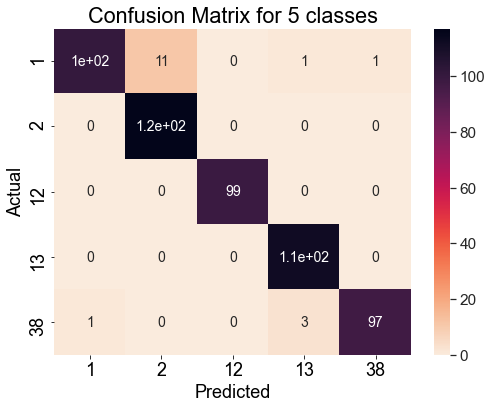

In [20]:
# Set figure size on this one
fig_size = (8,6)

creat_confusion_matrix_nice(cf_matrix_5cls,top_5_class_cln,fig_size)

An accuracy of 96.9% is really good. It looks like the model is having trouble predicting Class 0 which in this case is Class 1 in the true dataset (50 kph) speed sign. This is slightly odd. Since Class 0 and Class 1 are speed limit signs, it is somewhat confusing the two but not by a large margin. Let's check with all classes, i.e. 43 classes this time. 

### 43-Class Prediction

In [65]:
# Make sure the API endpoint url is up and running
api_endpoint_43 = 'https://akpj81752i.execute-api.us-west-2.amazonaws.com/german-traffic-signs-43cls-stage/german-traffic-signs-43-cls-res'

n_classes_43 = 43

main_folder = './'
lst_file_43 = f'{main_folder}/german_traffic_signs_test_43_classes.lst'

cf_matrix_43cls, accuracy_43cls = predict(api_endpoint_43, n_classes_43, lst_file_43)

prediction: data/Train/11/00011_00013_00018.png, 11, 11, 0.9999558925628662
prediction: data/Train/16/00016_00001_00017.png, 16, 16, 0.9999356269836426
prediction: data/Train/20/00020_00004_00001.png, 20, 20, 0.9998656511306763
prediction: data/Train/01/00001_00058_00025.png, 1, 1, 0.9825154542922974
prediction: data/Train/33/00033_00009_00000.png, 33, 33, 0.9991121888160706
prediction: data/Train/01/00001_00018_00021.png, 1, 1, 0.9718025326728821
prediction: data/Train/02/00002_00058_00024.png, 2, 2, 0.9961457252502441
prediction: data/Train/03/00003_00007_00026.png, 3, 3, 0.9990321397781372
prediction: data/Train/13/00013_00004_00029.png, 13, 13, 0.99997878074646
prediction: data/Train/05/00005_00057_00013.png, 5, 5, 0.9935368895530701
prediction: data/Train/25/00025_00000_00027.png, 25, 25, 0.9999773502349854
prediction: data/Train/13/00013_00028_00029.png, 13, 13, 0.9995866417884827
prediction: data/Train/10/00010_00049_00022.png, 10, 10, 0.9997977614402771
prediction: data/Train/3

prediction: data/Train/36/00036_00007_00014.png, 36, 36, 0.9999984502792358
prediction: data/Train/02/00002_00026_00014.png, 2, 2, 0.9955020546913147
prediction: data/Train/13/00013_00046_00027.png, 13, 13, 0.9944949746131897
prediction: data/Train/13/00013_00043_00026.png, 13, 13, 0.9996280670166016
prediction: data/Train/41/00041_00007_00014.png, 41, 41, 1.0
prediction: data/Train/38/00038_00004_00013.png, 38, 38, 0.9999986886978149
prediction: data/Train/07/00007_00021_00001.png, 7, 7, 0.8735091686248779
prediction: data/Train/31/00031_00013_00005.png, 31, 31, 0.9999943971633911
prediction: data/Train/12/00012_00058_00028.png, 12, 12, 0.9999855756759644
prediction: data/Train/41/00041_00006_00025.png, 41, 41, 1.0
prediction: data/Train/38/00038_00043_00011.png, 38, 38, 0.9999974966049194
prediction: data/Train/01/00001_00070_00012.png, 1, 1, 0.9861921072006226
prediction: data/Train/07/00007_00030_00007.png, 7, 7, 0.9981350898742676
prediction: data/Train/38/00038_00019_00004.png, 3

prediction: data/Train/10/00010_00064_00016.png, 10, 10, 0.9999809265136719
prediction: data/Train/18/00018_00014_00011.png, 18, 18, 0.9996726512908936
prediction: data/Train/08/00008_00018_00005.png, 8, 8, 0.9954957962036133
prediction: data/Train/42/00042_00007_00019.png, 42, 42, 0.9999986886978149
prediction: data/Train/40/00040_00009_00020.png, 40, 40, 1.0
prediction: data/Train/12/00012_00024_00018.png, 12, 12, 0.9999908208847046
prediction: data/Train/09/00009_00047_00012.png, 9, 9, 0.9996904134750366
prediction: data/Train/22/00022_00001_00008.png, 22, 22, 0.9979552030563354
prediction: data/Train/05/00005_00033_00027.png, 5, 5, 0.7033275365829468
prediction: data/Train/31/00031_00007_00022.png, 31, 31, 0.9998929500579834
prediction: data/Train/18/00018_00000_00022.png, 18, 18, 1.0
prediction: data/Train/35/00035_00023_00011.png, 35, 35, 0.9996932744979858
prediction: data/Train/17/00017_00008_00022.png, 17, 17, 0.9999111890792847
prediction: data/Train/13/00013_00068_00028.png,

prediction: data/Train/38/00038_00031_00023.png, 38, 38, 0.9999216794967651
prediction: data/Train/04/00004_00041_00008.png, 4, 4, 0.999997615814209
prediction: data/Train/07/00007_00004_00011.png, 7, 7, 0.99192214012146
prediction: data/Train/12/00012_00036_00015.png, 12, 12, 0.999995231628418
prediction: data/Train/02/00002_00027_00018.png, 2, 2, 0.9873214364051819
prediction: data/Train/02/00002_00060_00023.png, 2, 2, 0.9981977343559265
prediction: data/Train/06/00006_00000_00014.png, 6, 6, 0.9999973773956299
prediction: data/Train/02/00002_00036_00015.png, 2, 2, 0.999279797077179
prediction: data/Train/39/00039_00000_00027.png, 39, 39, 0.9999985694885254
prediction: data/Train/21/00021_00000_00001.png, 21, 21, 0.9990679621696472
prediction: data/Train/02/00002_00060_00028.png, 2, 2, 0.9962382316589355
prediction: data/Train/03/00003_00042_00015.png, 3, 3, 0.9996048808097839
prediction: data/Train/35/00035_00001_00027.png, 35, 35, 0.9999529123306274
prediction: data/Train/25/00025_0

prediction: data/Train/10/00010_00036_00006.png, 10, 10, 0.9995841383934021
prediction: data/Train/10/00010_00029_00021.png, 10, 10, 0.998174786567688
prediction: data/Train/04/00004_00054_00002.png, 4, 4, 0.9958317875862122
prediction: data/Train/22/00022_00011_00005.png, 22, 22, 0.9998296499252319
prediction: data/Train/01/00001_00046_00027.png, 2, 1, 0.6550508141517639
prediction: data/Train/12/00012_00059_00029.png, 12, 12, 0.9999754428863525
prediction: data/Train/02/00002_00046_00007.png, 2, 2, 0.9993956089019775
prediction: data/Train/05/00005_00019_00020.png, 5, 5, 0.7358471751213074
prediction: data/Train/05/00005_00002_00005.png, 5, 5, 0.9297325015068054
prediction: data/Train/13/00013_00067_00026.png, 13, 13, 0.999932050704956
prediction: data/Train/14/00014_00020_00005.png, 14, 14, 0.9999991655349731
prediction: data/Train/35/00035_00033_00007.png, 35, 35, 0.9999995231628418
prediction: data/Train/18/00018_00001_00025.png, 18, 18, 0.9999865293502808
prediction: data/Train/0

prediction: data/Train/04/00004_00033_00000.png, 4, 4, 0.5821762084960938
prediction: data/Train/17/00017_00007_00023.png, 17, 17, 0.9997130036354065
prediction: data/Train/27/00027_00004_00019.png, 27, 27, 0.999994158744812
prediction: data/Train/04/00004_00040_00017.png, 4, 4, 0.9999963045120239
prediction: data/Train/14/00014_00025_00018.png, 14, 14, 0.9999587535858154
prediction: data/Train/07/00007_00037_00006.png, 7, 7, 0.9997319579124451
prediction: data/Train/18/00018_00032_00004.png, 18, 18, 0.9999845027923584
prediction: data/Train/23/00023_00016_00008.png, 23, 23, 0.9943378567695618
prediction: data/Train/35/00035_00028_00027.png, 35, 35, 0.9999840259552002
prediction: data/Train/16/00016_00000_00026.png, 16, 16, 0.9983162879943848
prediction: data/Train/35/00035_00022_00001.png, 35, 35, 0.9998905658721924
prediction: data/Train/08/00008_00017_00027.png, 8, 8, 0.9996824264526367
prediction: data/Train/13/00013_00033_00003.png, 20, 13, 0.9902217388153076
prediction: data/Trai

prediction: data/Train/25/00025_00027_00029.png, 25, 25, 0.9999856948852539
prediction: data/Train/17/00017_00034_00018.png, 17, 17, 0.9998645782470703
prediction: data/Train/38/00038_00026_00005.png, 38, 38, 0.9999985694885254
prediction: data/Train/33/00033_00014_00026.png, 33, 33, 0.9999434947967529
prediction: data/Train/21/00021_00004_00010.png, 21, 21, 0.999859094619751
prediction: data/Train/09/00009_00010_00016.png, 9, 9, 0.9674698710441589
prediction: data/Train/16/00016_00004_00028.png, 16, 16, 0.9999650716781616
prediction: data/Train/08/00008_00035_00016.png, 8, 8, 0.9455558061599731
prediction: data/Train/23/00023_00014_00014.png, 23, 23, 0.9992935657501221
prediction: data/Train/14/00014_00015_00023.png, 14, 14, 0.9999969005584717
prediction: data/Train/38/00038_00002_00000.png, 38, 38, 0.999994158744812
prediction: data/Train/05/00005_00004_00026.png, 5, 5, 0.5959410071372986
prediction: data/Train/33/00033_00019_00027.png, 33, 33, 0.9995506405830383
prediction: data/Tra

prediction: data/Train/25/00025_00024_00029.png, 25, 25, 0.9999691247940063
prediction: data/Train/02/00002_00020_00002.png, 2, 2, 0.9999599456787109
prediction: data/Train/11/00011_00018_00029.png, 41, 11, 0.6642204523086548
prediction: data/Train/05/00005_00044_00020.png, 5, 5, 0.9956771731376648
prediction: data/Train/04/00004_00020_00027.png, 4, 4, 0.9999953508377075
prediction: data/Train/19/00019_00003_00020.png, 19, 19, 1.0
prediction: data/Train/15/00015_00015_00020.png, 15, 15, 0.9999871253967285
prediction: data/Train/02/00002_00008_00003.png, 2, 2, 0.9993720650672913
prediction: data/Train/04/00004_00003_00016.png, 4, 4, 0.9999990463256836
prediction: data/Train/25/00025_00032_00007.png, 25, 25, 0.9999710321426392
prediction: data/Train/08/00008_00031_00018.png, 8, 8, 0.9489563703536987
prediction: data/Train/31/00031_00006_00007.png, 31, 31, 0.9999949932098389
prediction: data/Train/23/00023_00003_00021.png, 23, 23, 0.9999617338180542
prediction: data/Train/04/00004_00026_0

prediction: data/Train/13/00013_00059_00010.png, 13, 13, 0.9999517202377319
prediction: data/Train/10/00010_00049_00020.png, 10, 10, 0.9999463558197021
prediction: data/Train/38/00038_00021_00011.png, 38, 38, 0.9999923706054688
prediction: data/Train/31/00031_00016_00009.png, 31, 31, 0.999935507774353
prediction: data/Train/12/00012_00055_00004.png, 12, 12, 0.9999957084655762
prediction: data/Train/26/00026_00009_00016.png, 26, 26, 0.9999998807907104
prediction: data/Train/41/00041_00003_00022.png, 41, 41, 0.9997410178184509
prediction: data/Train/01/00001_00022_00013.png, 2, 1, 0.6284509897232056
prediction: data/Train/08/00008_00004_00000.png, 8, 8, 0.9985619187355042
prediction: data/Train/11/00011_00001_00009.png, 30, 11, 0.9983623623847961
prediction: data/Train/31/00031_00006_00026.png, 31, 31, 0.9999979734420776
prediction: data/Train/33/00033_00017_00029.png, 33, 33, 0.9993059635162354
prediction: data/Train/02/00002_00005_00008.png, 2, 2, 0.9177634716033936
prediction: data/Tr

prediction: data/Train/14/00014_00014_00013.png, 14, 14, 0.9996858835220337
prediction: data/Train/28/00028_00016_00001.png, 28, 28, 0.9999727010726929
prediction: data/Train/35/00035_00009_00020.png, 35, 35, 0.9995947480201721
prediction: data/Train/11/00011_00006_00001.png, 11, 11, 0.9960305094718933
prediction: data/Train/20/00020_00006_00024.png, 20, 20, 0.9999690055847168
prediction: data/Train/09/00009_00008_00025.png, 9, 9, 0.9989796280860901
prediction: data/Train/25/00025_00042_00008.png, 25, 25, 0.9999910593032837
prediction: data/Train/12/00012_00004_00026.png, 12, 12, 0.9992896318435669
prediction: data/Train/17/00017_00021_00009.png, 17, 17, 0.9996993541717529
prediction: data/Train/10/00010_00048_00014.png, 10, 10, 0.9999880790710449
prediction: data/Train/13/00013_00019_00010.png, 13, 13, 0.9998891353607178
prediction: data/Train/18/00018_00009_00010.png, 18, 18, 1.0
prediction: data/Train/13/00013_00012_00025.png, 13, 13, 0.9998410940170288
prediction: data/Train/02/000

prediction: data/Train/07/00007_00008_00013.png, 7, 7, 0.990754246711731
prediction: data/Train/22/00022_00000_00026.png, 22, 22, 0.9964622855186462
prediction: data/Train/04/00004_00029_00027.png, 4, 4, 0.9999110698699951
prediction: data/Train/17/00017_00020_00017.png, 17, 17, 0.999495267868042
prediction: data/Train/17/00017_00033_00004.png, 17, 17, 0.9996916055679321
prediction: data/Train/13/00013_00021_00018.png, 13, 13, 0.9998685121536255
prediction: data/Train/25/00025_00033_00004.png, 25, 25, 0.9999654293060303
prediction: data/Train/12/00012_00034_00024.png, 12, 12, 0.9998509883880615
prediction: data/Train/35/00035_00029_00029.png, 35, 35, 0.9999948740005493
prediction: data/Train/30/00030_00012_00020.png, 30, 30, 0.9430992007255554
prediction: data/Train/14/00014_00011_00026.png, 14, 14, 0.999954342842102
prediction: data/Train/08/00008_00021_00029.png, 2, 8, 0.613614022731781
prediction: data/Train/23/00023_00006_00008.png, 23, 23, 0.9999700784683228
prediction: data/Train

prediction: data/Train/30/00030_00002_00018.png, 30, 30, 0.9999711513519287
prediction: data/Train/05/00005_00045_00013.png, 5, 5, 0.845571756362915
prediction: data/Train/02/00002_00009_00002.png, 2, 2, 0.6798285841941833
prediction: data/Train/13/00013_00027_00001.png, 13, 13, 0.9999202489852905
prediction: data/Train/02/00002_00066_00005.png, 2, 2, 0.9978787899017334
prediction: data/Train/05/00005_00036_00000.png, 5, 5, 0.92522794008255
prediction: data/Train/38/00038_00026_00008.png, 38, 38, 0.9999997615814209
prediction: data/Train/21/00021_00001_00010.png, 21, 21, 0.9999806880950928
prediction: data/Train/39/00039_00008_00004.png, 39, 39, 0.9999998807907104
prediction: data/Train/31/00031_00010_00005.png, 31, 31, 0.9998666048049927
prediction: data/Train/12/00012_00011_00025.png, 12, 12, 0.9999979734420776
prediction: data/Train/13/00013_00029_00006.png, 13, 13, 0.9997391104698181
prediction: data/Train/03/00003_00032_00010.png, 3, 3, 0.9699393510818481
prediction: data/Train/13

prediction: data/Train/10/00010_00034_00016.png, 10, 10, 0.9996199607849121
prediction: data/Train/31/00031_00016_00016.png, 31, 31, 0.9999426603317261
prediction: data/Train/01/00001_00061_00009.png, 1, 1, 0.954443633556366
prediction: data/Train/04/00004_00032_00023.png, 4, 4, 0.9997591376304626
prediction: data/Train/12/00012_00033_00005.png, 12, 12, 0.9999934434890747
prediction: data/Train/39/00039_00002_00022.png, 39, 39, 1.0
prediction: data/Train/13/00013_00009_00010.png, 13, 13, 0.9992671608924866
prediction: data/Train/18/00018_00015_00017.png, 18, 18, 0.99991774559021
prediction: data/Train/23/00023_00002_00003.png, 23, 23, 0.9993366599082947
prediction: data/Train/09/00009_00044_00011.png, 9, 9, 0.9999953508377075
prediction: data/Train/03/00003_00028_00021.png, 3, 3, 0.9980552196502686
prediction: data/Train/01/00001_00051_00019.png, 1, 1, 0.9650747179985046
prediction: data/Train/01/00001_00056_00000.png, 1, 1, 0.7457987070083618
prediction: data/Train/11/00011_00024_0000

prediction: data/Train/41/00041_00002_00018.png, 41, 41, 1.0
prediction: data/Train/38/00038_00002_00026.png, 38, 38, 0.9999916553497314
prediction: data/Train/04/00004_00015_00004.png, 4, 4, 0.9999572038650513
prediction: data/Train/11/00011_00030_00028.png, 11, 11, 0.9998683929443359
prediction: data/Train/17/00017_00015_00025.png, 17, 17, 0.9996265172958374
prediction: data/Train/32/00032_00007_00017.png, 32, 32, 0.9998189806938171
prediction: data/Train/36/00036_00010_00020.png, 36, 36, 0.9999861717224121
prediction: data/Train/10/00010_00006_00001.png, 10, 10, 0.9999204874038696
prediction: data/Train/35/00035_00035_00010.png, 35, 35, 0.999824583530426
prediction: data/Train/23/00023_00011_00013.png, 23, 23, 0.9988399147987366
prediction: data/Train/23/00023_00013_00021.png, 23, 23, 0.9999693632125854
prediction: data/Train/13/00013_00015_00026.png, 13, 13, 0.9970032572746277
prediction: data/Train/09/00009_00041_00006.png, 9, 9, 0.9992916584014893
prediction: data/Train/03/00003_

prediction: data/Train/35/00035_00007_00005.png, 35, 35, 0.999245285987854
prediction: data/Train/04/00004_00048_00017.png, 4, 4, 0.99998939037323
prediction: data/Train/13/00013_00053_00000.png, 13, 13, 0.9997327923774719
prediction: data/Train/31/00031_00017_00003.png, 31, 31, 0.9999507665634155
prediction: data/Train/02/00002_00036_00021.png, 2, 2, 0.9877194166183472
prediction: data/Train/09/00009_00029_00013.png, 9, 9, 0.9999608993530273
prediction: data/Train/11/00011_00032_00025.png, 11, 11, 0.9999713897705078
prediction: data/Train/05/00005_00050_00016.png, 2, 5, 0.6170108318328857
prediction: data/Train/40/00040_00004_00022.png, 40, 40, 0.9999583959579468
prediction: data/Train/05/00005_00050_00026.png, 5, 5, 0.7196778059005737
prediction: data/Train/07/00007_00003_00023.png, 7, 7, 0.9979597330093384
prediction: data/Train/23/00023_00006_00006.png, 23, 23, 0.9999028444290161
prediction: data/Train/05/00005_00023_00007.png, 5, 5, 0.9605445265769958
prediction: data/Train/18/000

prediction: data/Train/07/00007_00023_00008.png, 7, 7, 0.9993822574615479
prediction: data/Train/32/00032_00007_00029.png, 32, 32, 0.9999972581863403
prediction: data/Train/03/00003_00044_00021.png, 3, 3, 0.9966412782669067
prediction: data/Train/10/00010_00009_00016.png, 10, 10, 0.9999083280563354
prediction: data/Train/05/00005_00000_00008.png, 5, 5, 0.9530103802680969
prediction: data/Train/23/00023_00007_00019.png, 23, 23, 0.9999040365219116
prediction: data/Train/05/00005_00019_00025.png, 2, 5, 0.6306525468826294
prediction: data/Train/12/00012_00059_00000.png, 12, 12, 0.9999921321868896
prediction: data/Train/12/00012_00060_00007.png, 12, 12, 0.9991157650947571
prediction: data/Train/30/00030_00006_00003.png, 30, 30, 0.9994575381278992
prediction: data/Train/12/00012_00019_00022.png, 12, 12, 0.9996566772460938
prediction: data/Train/25/00025_00039_00023.png, 25, 25, 0.9997156262397766
prediction: data/Train/40/00040_00009_00025.png, 40, 40, 0.9999988079071045
prediction: data/Tra

prediction: data/Train/26/00026_00019_00021.png, 26, 26, 0.9999969005584717
prediction: data/Train/09/00009_00044_00007.png, 9, 9, 0.9985333681106567
prediction: data/Train/35/00035_00024_00015.png, 35, 35, 0.9999990463256836
prediction: data/Train/41/00041_00006_00029.png, 41, 41, 0.9999992847442627
prediction: data/Train/03/00003_00034_00011.png, 3, 3, 0.9999251365661621
prediction: data/Train/17/00017_00034_00022.png, 17, 17, 0.9999102354049683
prediction: data/Train/35/00035_00027_00021.png, 35, 35, 0.9974848031997681
prediction: data/Train/18/00018_00031_00003.png, 18, 18, 0.9999997615814209
prediction: data/Train/23/00023_00004_00018.png, 23, 23, 0.9996609687805176
prediction: data/Train/07/00007_00025_00021.png, 7, 7, 0.9966700673103333
prediction: data/Train/08/00008_00000_00006.png, 8, 8, 0.9504243731498718
prediction: data/Train/05/00005_00021_00005.png, 5, 5, 0.4535827934741974
prediction: data/Train/29/00029_00005_00009.png, 29, 29, 0.9999760389328003
prediction: data/Train

prediction: data/Train/10/00010_00044_00028.png, 10, 10, 0.9970092177391052
prediction: data/Train/05/00005_00028_00019.png, 5, 5, 0.5886057019233704
prediction: data/Train/12/00012_00007_00003.png, 12, 12, 0.9999984502792358
prediction: data/Train/39/00039_00006_00025.png, 39, 39, 1.0
prediction: data/Train/22/00022_00011_00028.png, 22, 22, 0.9999959468841553
prediction: data/Train/31/00031_00008_00003.png, 31, 31, 0.9999433755874634
prediction: data/Train/19/00019_00003_00013.png, 19, 19, 0.9999994039535522
prediction: data/Train/08/00008_00012_00025.png, 8, 8, 0.9991360306739807
prediction: data/Train/19/00019_00000_00017.png, 19, 19, 0.9997861981391907
prediction: data/Train/04/00004_00021_00019.png, 4, 4, 0.9999487400054932
prediction: data/Train/03/00003_00019_00024.png, 3, 3, 0.9993581175804138
prediction: data/Train/30/00030_00012_00017.png, 30, 30, 0.8517378568649292
prediction: data/Train/19/00019_00000_00010.png, 21, 19, 0.9637160897254944
prediction: data/Train/18/00018_000

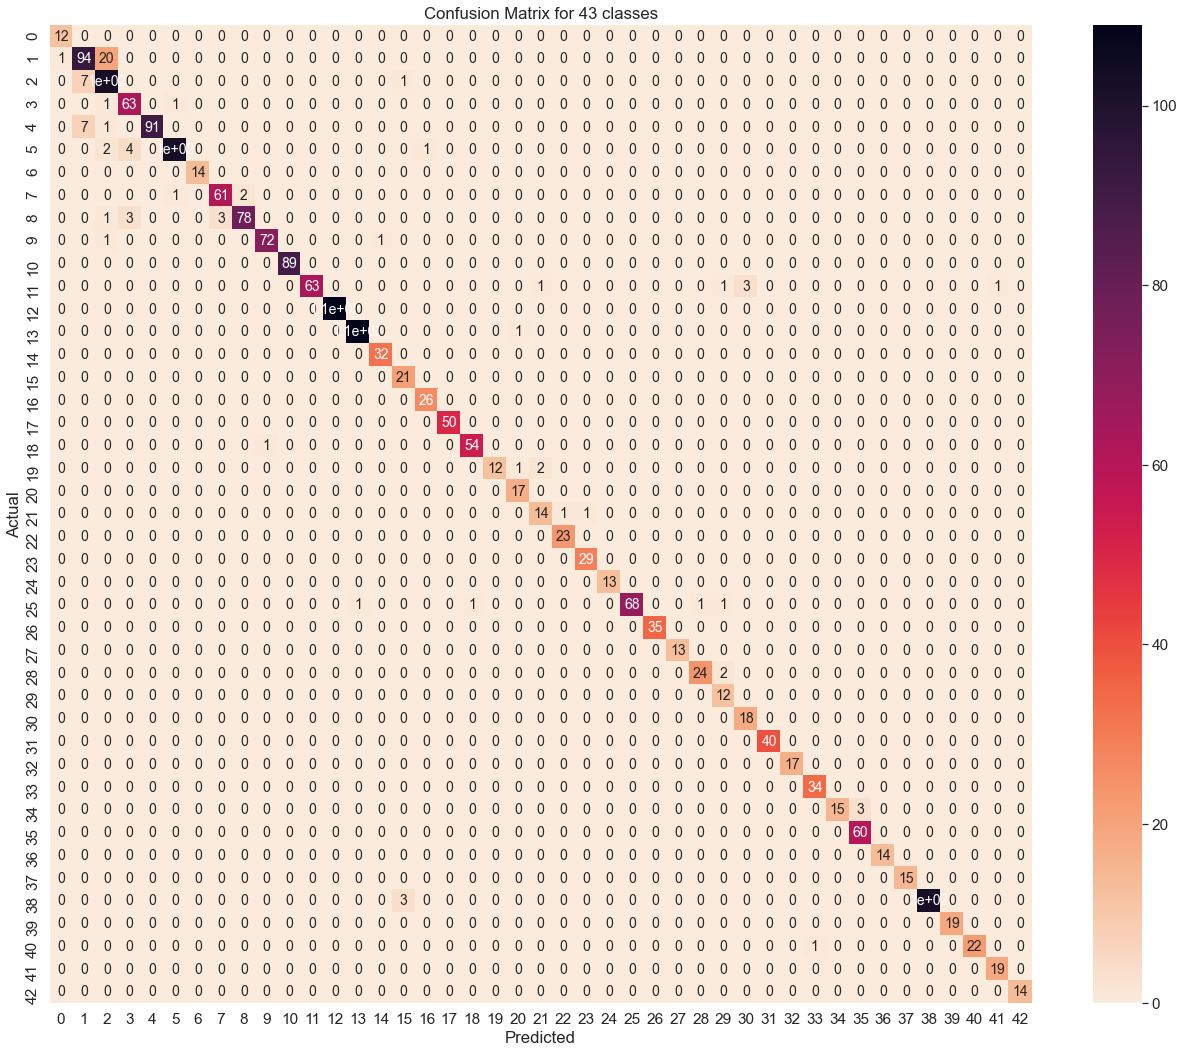

0.9575328614762386


In [59]:
# Set figure size on this one
fig_size = (22,18)

class_list_43 = [x for x in range(0,43)]

creat_confusion_matrix_nice(cf_matrix_43cls, class_list_43, fig_size)

print(accuracy_43cls)

## Closing Remarks

Here for 43 classes we are seeing an accuracy of **95.7%** which is still fantastic! Note that the dataset is severely imbalanced but yet is still able to reach an accuracy that is really high. 

From the confusion matrix above, it is clear that the classifier has a little trouble with the speed limit signs where it confuses Class 1 and Class 2, i.e. 30 and 50 kph. This could potentially be due to the image quality. I noticed that some of the speed signs are really dark and hard to make out.

A classifier will have problems with this. Thinking of this holistically, if a self-driving car is unable to determine the speed limit in a residential neighborhood, this can be really dangerous. If the speed limit is 30 kph but mis-classifies it as 50 kph, a speed ticket could be issued. Furthermore, if there are pedestrians, will the vehicle be able to stop in time to avoid an accident?

Perhaps care needs to be taken when training image recognition especially for self-driving cars. The next steps could be:

1. Train ResNet from scratch on the entire dataset


2. Have more image data distinguishing Class 1 and Class 2 more clearly OR look closely as to which images were misclassified especially for Class 2. In this case, the prediction function will need to be slightly modified to dump out the real-time predictions to either a csv or json file. From there it can be further analyzed.


3. Discard bad images beforehand. Note that some traffic signs were vandalized and that made the numbers on the sign not visible.


**The biggest take-home message from this project is that the training and validation dataset need to be shuffled properly beforehand. This has improved the accuracy tremendously!**